In [10]:
import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Machine learning engineering

Most of the interesting part of machine learning engineering is in the building of architectures and optimization algorithms.
In this notebook we will explore different aspects of a neural network, and the effect of changing the architecture and the optimization algorithms.

In [12]:
def fwd_pass(net, X:Tensor, y:Tensor, device, optimizer, train=False):
    """
    This function controls the machine learning steps, depending on if we are in training mode or not.
    """
    if train:
        net.train()
        net.zero_grad()
    outputs = net(X.to(device))
    loss = F.mse_loss(outputs, y.to(device)).to(device)
    if train:
        loss.backward()
        optimizer.step()
    return loss

def train(net, traindata, testdata, batchsize:int, epochs:int, device, optimizer):
    """
    Trains the model for the number of epochs specified, using the batch size specified.
    Returns a dataframe with the stats from the training.
    """
    dataset = DataLoader(traindata, batchsize, shuffle=True)
    df_labels = ["Loss", "Validation loss", "Epoch", "Iteration"]
    df_data = [[0], [0], [0], [0]]
    df = pd.DataFrame(dict(zip(df_labels, df_data)))
    i = 0
    for epoch in tqdm(range(epochs)):
        for data in dataset:
            i = i+1
            X, y = data
            #print(X[0], y[0])
            loss = fwd_pass(net, X, y, device, optimizer, train=True)
            #acc, loss = test(net, testdata, size=size)
            if i % 10 == 0:
                val_loss = test(net, testdata, device, optimizer, batchsize)
                df_data = [float(loss), float(val_loss), epoch, i]
                new_df = pd.DataFrame(dict(zip(df_labels, df_data)), index=[0])
                df = pd.concat([df, new_df], ignore_index=True)
            
    return df

def test(net, data, device, optimizer, size:int = 32):
    """
    Calculates the accuracy and the loss of the model for a random batch.
    """
    net.eval()
    dataset = DataLoader(data, size, shuffle=True) #shuffle data and choose batch size
    X, y = next(iter(dataset)) #get a random batch
    val_loss = fwd_pass(net, X, y, device, optimizer, train=False)
    return val_loss
    
def predict(net, testdata, size:int, device):
    """
    Calculates the accuracy and the loss of the model in testing mode.
    If return_loss is True, it will return the loss for each datapoint.
    It can also return the softmax values of the raw output from the model.
    Does not shuffle the data.
    """
    dataset = DataLoader(testdata, size, shuffle=False) #shuffle data and choose batch size
    prediction = torch.zeros((len(dataset), size))
    truth = torch.zeros((len(dataset), size))
    i = 0
    net.eval()
    with torch.no_grad():
        for data in tqdm(dataset):
            X, y = data
            outputs = net(X.to(device))
            prediction[i] = outputs
            truth[i] = y
            i = i+1
    return torch.flatten(truth), torch.flatten(prediction)

### Neural network

We create a very simple neural network with a few layers and some specific activation functions.

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, activation:str, in_channels:int, out_channels:int, L: int = 1024, n_hidden:int = 1):
        assert activation in ["relu", "tanh"], "should be a a valid activation function"
        super().__init__()
        self.activation = activation
        self.L = L
        self.n_hidden = n_hidden
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.flatten = nn.Flatten()
        self.first_layer = nn.Linear(in_channels, L)
        self.hidden_layer = nn.Linear(L, L)
        self.last_layer = nn.Linear(L, out_channels)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        identity = x
        x = self.first_layer(x)
        for i in range(self.n_hidden):
            x = self.hidden_layer(x)
            if self.activation == "relu":
                x = self.relu(x)
            elif self.activation == "tanh":
                x = self.tanh(x)
        x = self.last_layer(x)
        return x

In [14]:
def plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, ax, zoom=False):
    ax.plot(X_test, Y_test, color="orange", label = "Generating function")
    ax.scatter(X_test, preds.flatten().cpu().numpy(), s=1, label="Prediction")
    ax.legend()
    ax.plot([xmin, xmin], [10, -10], color = "red")
    ax.plot([xmax, xmax], [10, -10], color = "red")
    ax.plot([xmin + (xmax-xmin)/2 - int_step, xmin + (xmax-xmin)/2 - int_step], [10, -10], color = "red")
    ax.plot([xmin + (xmax-xmin)/2 + int_step, xmin + (xmax-xmin)/2 + int_step], [10, -10], color = "red")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if zoom:
        ax.set_xlim(xmin + (xmax-xmin)/2 - int_step, xmin + (xmax-xmin)/2 + int_step)
        ax.set_ylim(-2.5, 2.5)
    else: ax.set_ylim(-5, 5)

### Data

We want to explore the fitting ability on data drawn from the same range as the training data as well as the interpolation ability between training data groups (if the data is grouped) and the extrapolation ability outside the training range.

In [26]:
# Data
def function(x):
    y = torch.sin(x*10+3) + torch.log(x) + torch.randn(len(x)).to(device)
    print(y.shape)
    return (y)
    #return (x**2 + 3*x)

xmin = 0
xmax = 3
int_step = (xmax-xmin)/20
#Generate data
ntrain = 4000
rng = np.random.default_rng()
X_train_left = torch.tensor(rng.uniform(xmin, xmin + (xmax-xmin)/2 - int_step, ntrain).reshape(ntrain, 1), device=device).to(torch.float32)
X_train_right = torch.tensor(rng.uniform(xmin + (xmax-xmin)/2+int_step, xmax, ntrain).reshape(ntrain, 1), device=device).to(torch.float32)
X_train = torch.concat((X_train_left, X_train_right))
# Reshuffle
rand_indx = torch.randperm(len(X_train))
X_train = X_train[rand_indx]
Y_train = function(X_train).reshape(ntrain*2, 1).to(torch.float32)

nval = 100
X_val_left = torch.tensor(rng.uniform(xmin, xmin + (xmax-xmin)/2 - int_step, nval).reshape(nval, 1), device=device).to(torch.float32)
X_val_right = torch.tensor(rng.uniform(xmin + (xmax-xmin)/2+int_step, xmax, nval).reshape(nval, 1), device=device).to(torch.float32)
X_val = torch.concat((X_val_left, X_val_right))
Y_val = function(X_val).reshape(nval*2, 1).to(torch.float32)

# Plot the training data
X_plot = X_train.flatten().cpu().numpy()
Y_plot = Y_train.flatten().cpu().numpy()

# Test data
ntest = 1000
X_test = torch.linspace(xmin-1, xmax+1, ntest).reshape(ntest, 1).to(torch.float32)
Y_test = function(X_test).reshape(ntest, 1).to(torch.float32)
plt.scatter(X_test, Y_test, color="orange", label = "Generating function", s=1)

plt.scatter(X_plot, Y_plot, s=5, label="Training data")

plt.legend()
#plt.ylim(-5, 15)

torch.Size([8000, 8000])


RuntimeError: shape '[8000, 1]' is invalid for input of size 64000000

In [7]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

### Initital "predictions"

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1599.27it/s]


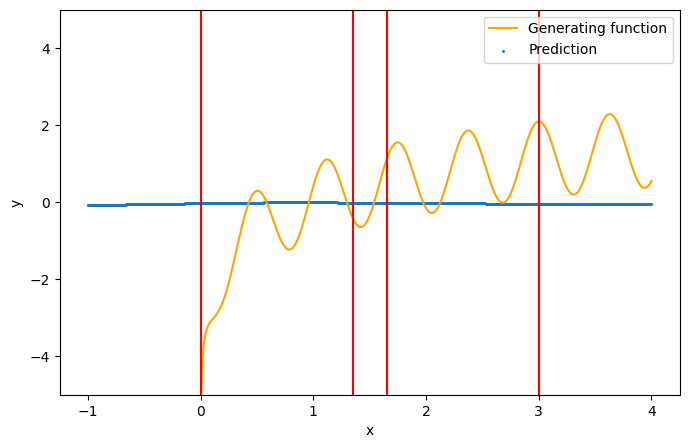

In [8]:
model = NeuralNetwork(L=512, n_hidden=2, activation="tanh", in_channels=1, out_channels=1).to(device)
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 5))
truth, preds = predict(model, test_dataset, 1, device)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs)

### ReLu activation function, SGD optimizer, 512 nodes in 1 hidden layer

100%|██████████| 1000/1000 [00:00<00:00, 2037.72it/s]


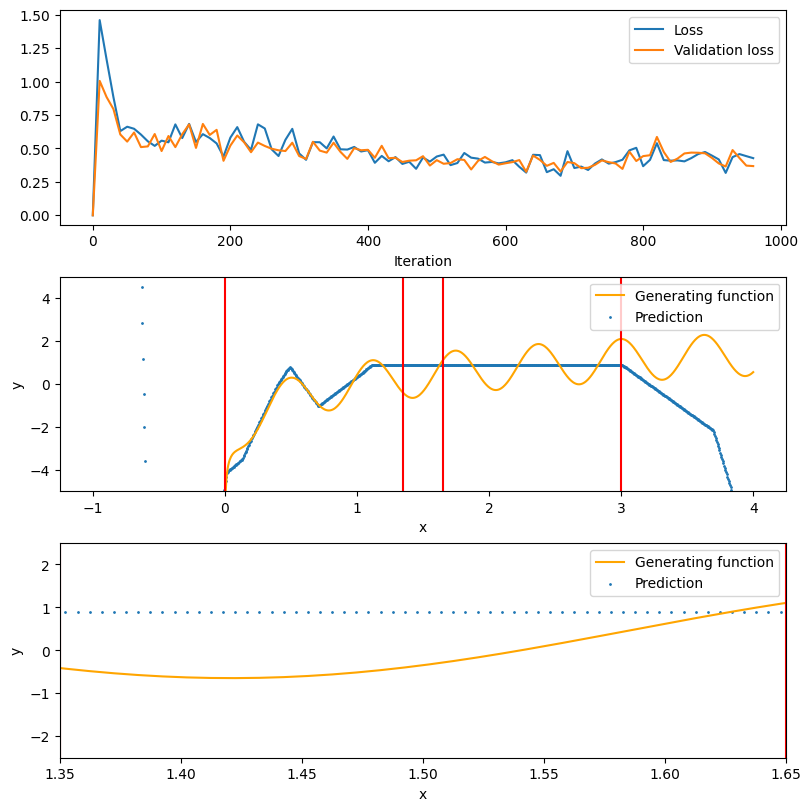

In [178]:
model = NeuralNetwork(L=512, n_hidden=1, activation="relu", in_channels=1, out_channels=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=1)
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 30, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)

### ReLu activation function, SGD optimizer, 1024 nodes in 1 hidden layer

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2010.38it/s]


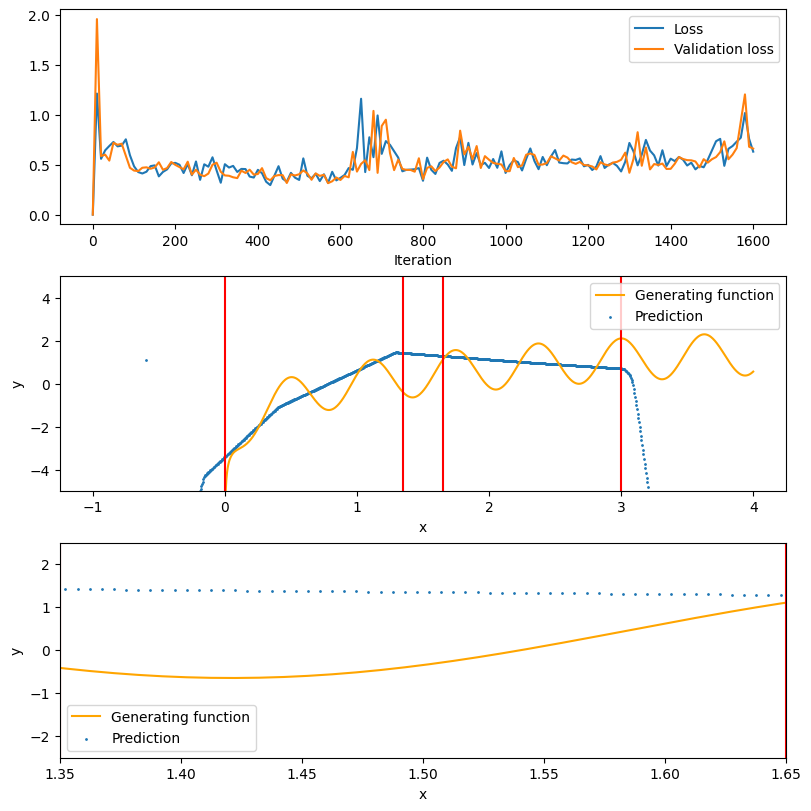

In [179]:
model = NeuralNetwork(L=1024, n_hidden=1, activation="relu", in_channels=1, out_channels=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=1)
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 50, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)

### ReLu activation function, SGD optimizer, 512 nodes in 3 hidden layers

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1407.03it/s]


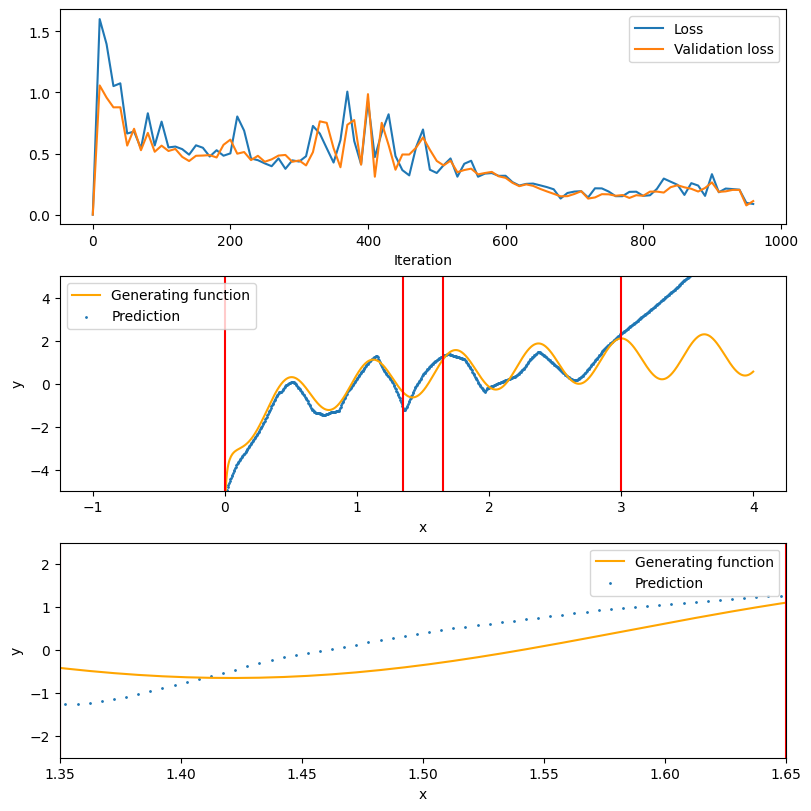

In [181]:
model = NeuralNetwork(L=512, n_hidden=3, activation="relu", in_channels=1, out_channels=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=1)
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 30, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)

### ReLu activation function, SGD optimizer, 1024 nodes in 5 hidden layers

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1075.78it/s]


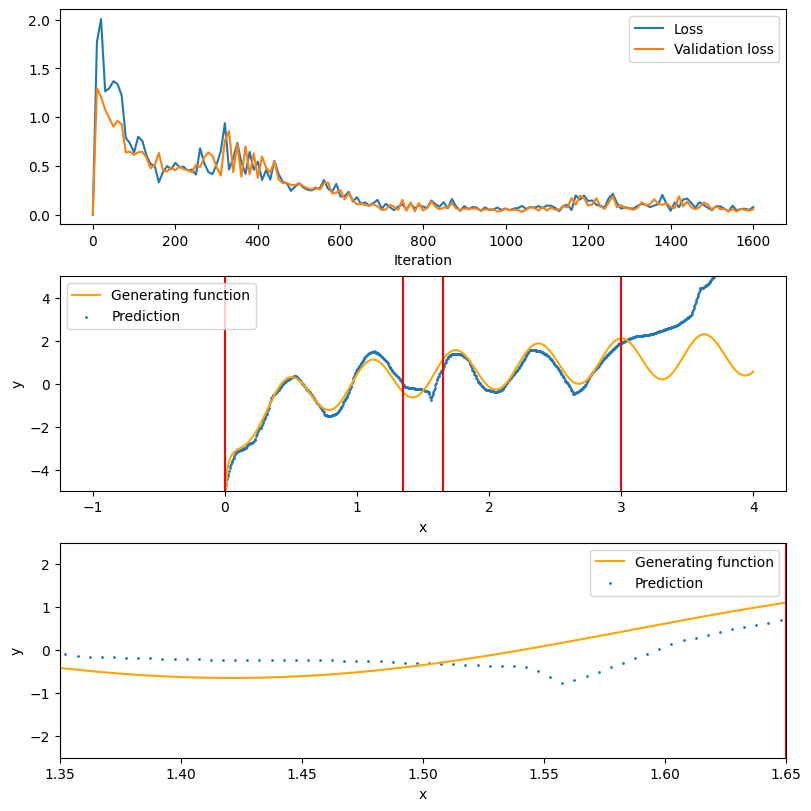

In [127]:
model = NeuralNetwork(L=1024, n_hidden=5, activation="relu", in_channels=1, out_channels=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=1)
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 50, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)

### Tanh activation function, SGD optimizer, 1024 nodes in 5 hidden layers

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1092.45it/s]


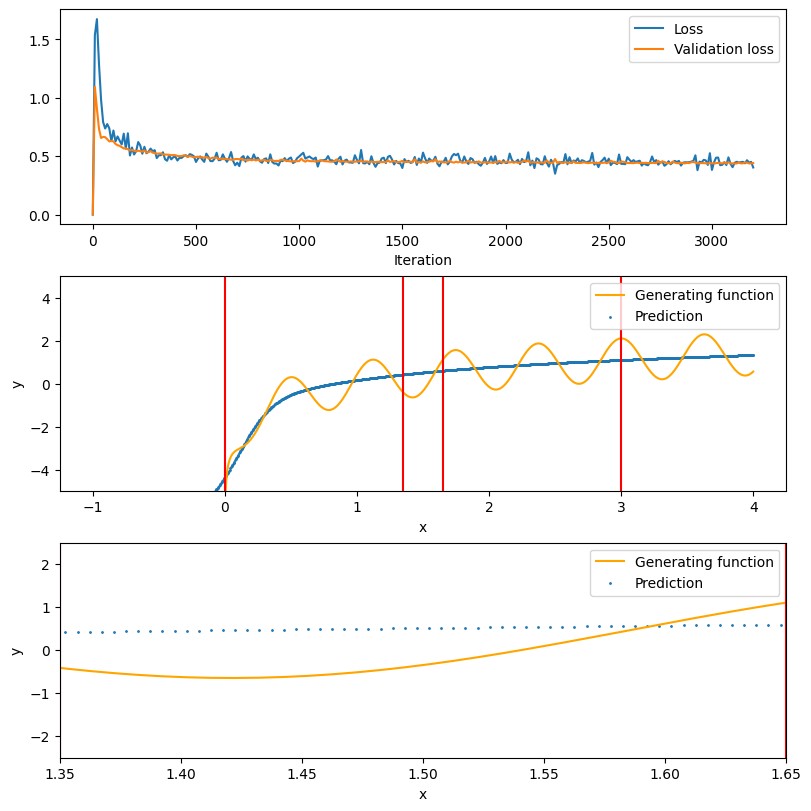

In [128]:
model = NeuralNetwork(L=1024, n_hidden=5, activation="tanh", in_channels=1, out_channels=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 100, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)

### ReLu activation function, Adam optimizer, 512 nodes in 1 hidden layer

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1989.89it/s]


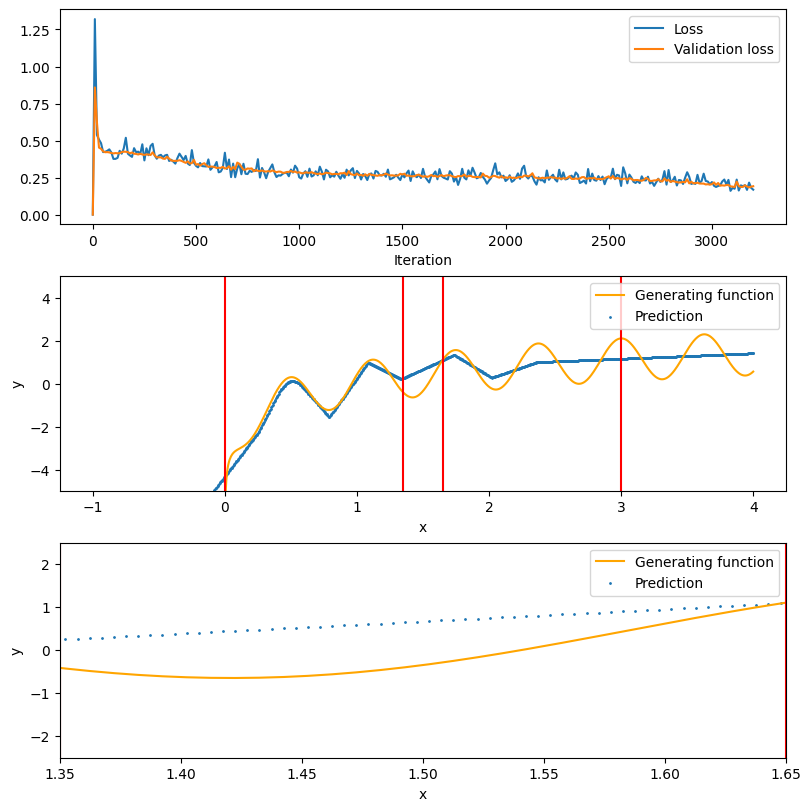

In [182]:
model = NeuralNetwork(L=512, n_hidden=1, activation="relu", in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 100, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)

### Tanh activation function, Adam optimizer, 512 nodes in 1 hidden layer

100%|██████████| 1000/1000 [00:00<00:00, 2036.08it/s]


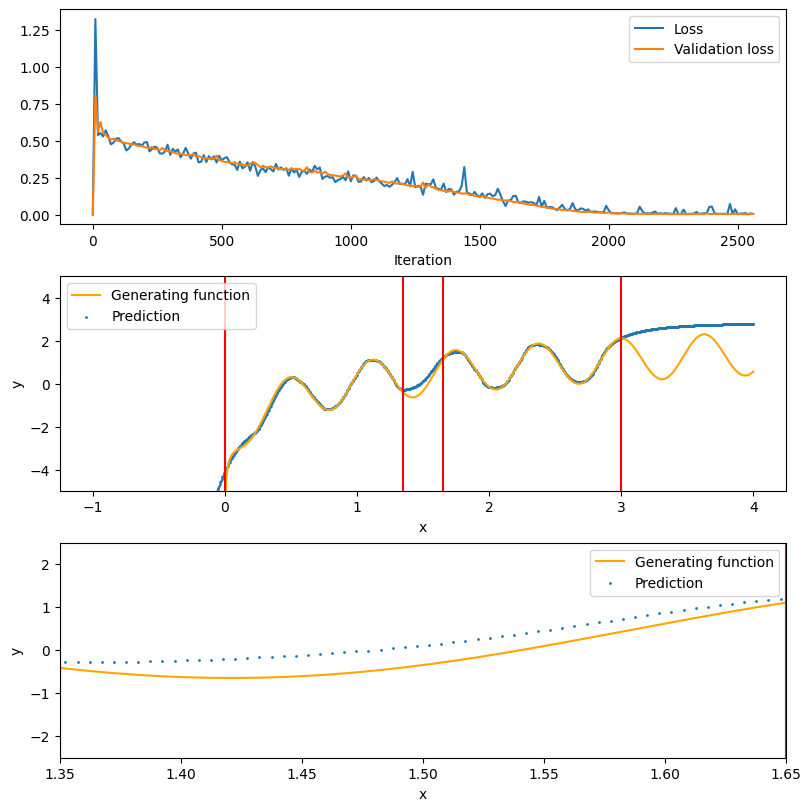

In [130]:
model = NeuralNetwork(L=512, n_hidden=1, activation="tanh", in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 80, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)

### ReLu activation function, Adam optimizer, 512 nodes in 3 hidden layers

100%|██████████| 1000/1000 [00:00<00:00, 1414.67it/s]


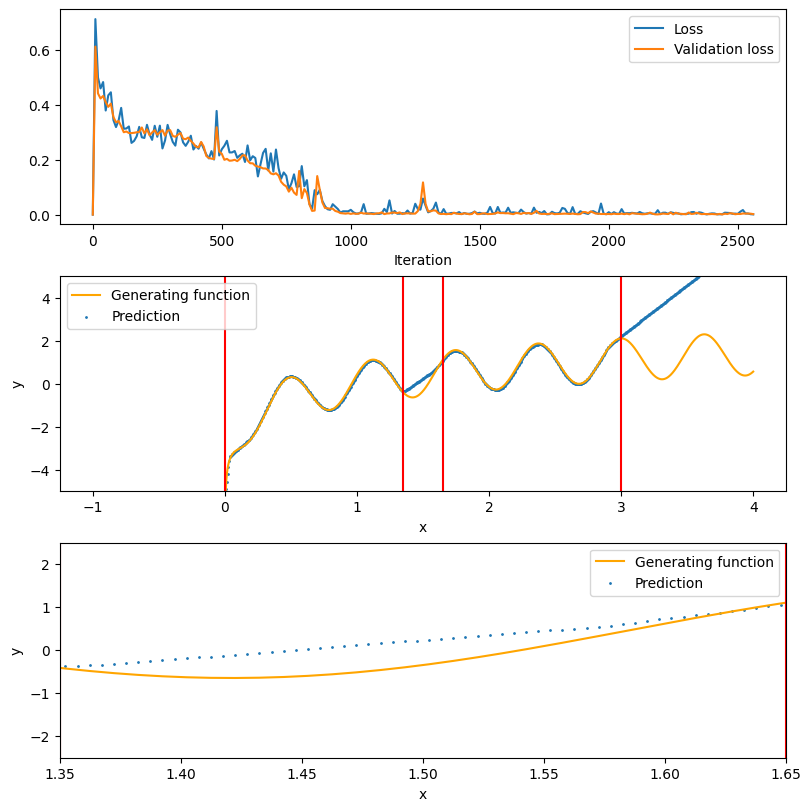

In [131]:
model = NeuralNetwork(L=512, n_hidden=3, activation="relu", in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 80, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)

### Tanh activation function, Adam optimizer, 512 nodes in 3 hidden layers

100%|██████████| 1000/1000 [00:00<00:00, 1426.24it/s]


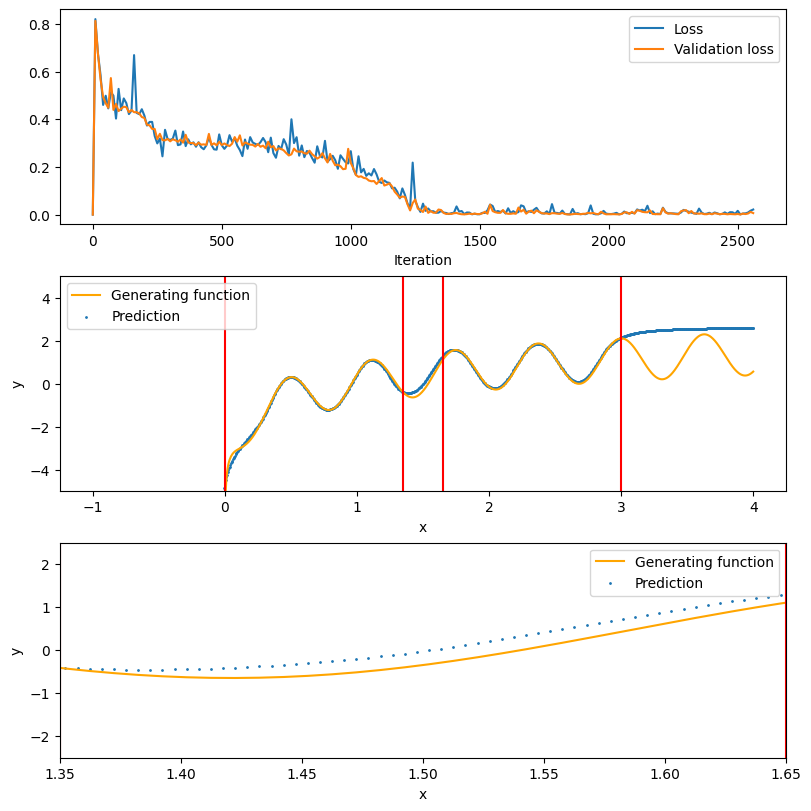

In [132]:
model = NeuralNetwork(L=512, n_hidden=3, activation="tanh", in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 80, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)

### Tanh activation function, Adam optimizer, 128 nodes in 3 hidden layers

100%|██████████| 1000/1000 [00:00<00:00, 1427.87it/s]


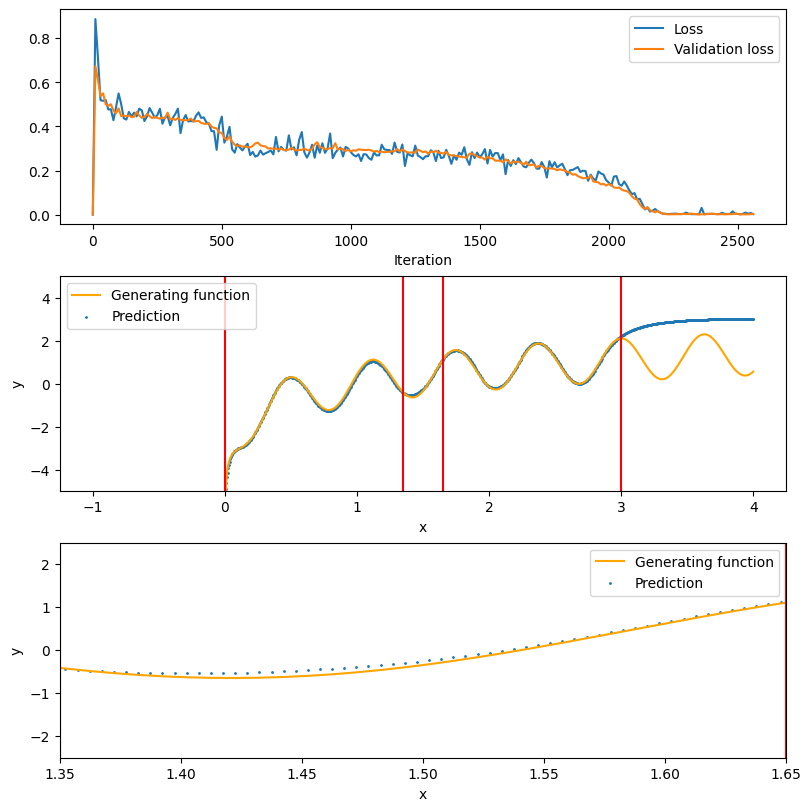

In [133]:
model = NeuralNetwork(L=128, n_hidden=3, activation="tanh", in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 80, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)

### Tanh activation function, Adam optimizer, 64 nodes in 3 hidden layers

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1429.14it/s]


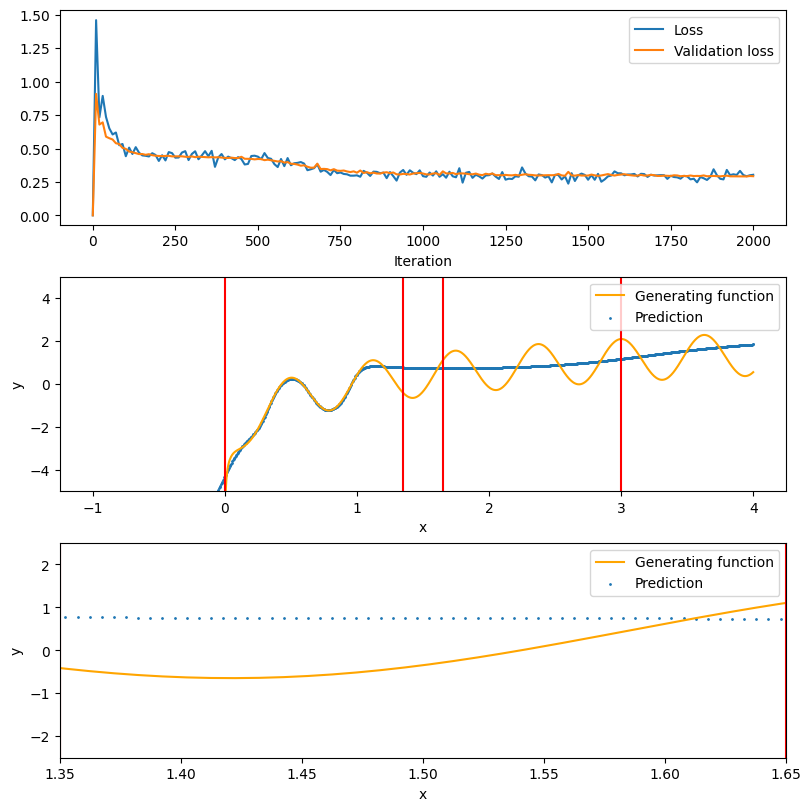

In [145]:
model = NeuralNetwork(L=64, n_hidden=3, activation="tanh", in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 250, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)

### Tanh activation function, Adam optimizer, 512 nodes in 3 hidden layers, 2000 datapoints

100%|██████████| 1000/1000 [00:00<00:00, 1412.42it/s]


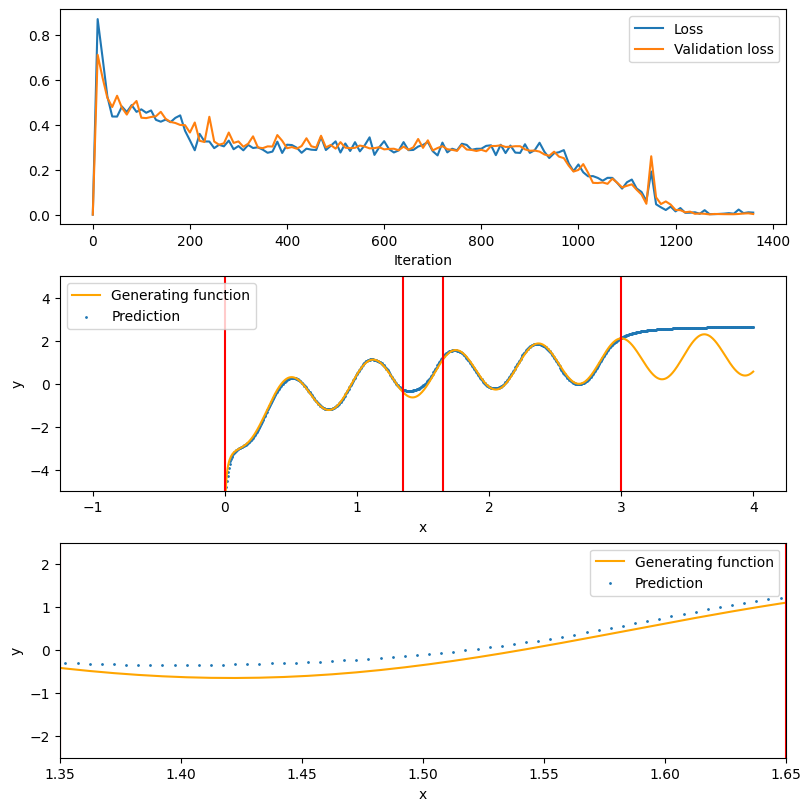

In [143]:
model = NeuralNetwork(L=512, n_hidden=3, activation="tanh", in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_dataset = torch.utils.data.TensorDataset(X_train[0:2000], Y_train[0:2000])
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 170, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)

### Tanh activation function, Adam optimizer, 512 nodes in 3 hidden layers, 50 datapoints

100%|██████████| 1000/1000 [00:00<00:00, 1424.45it/s]


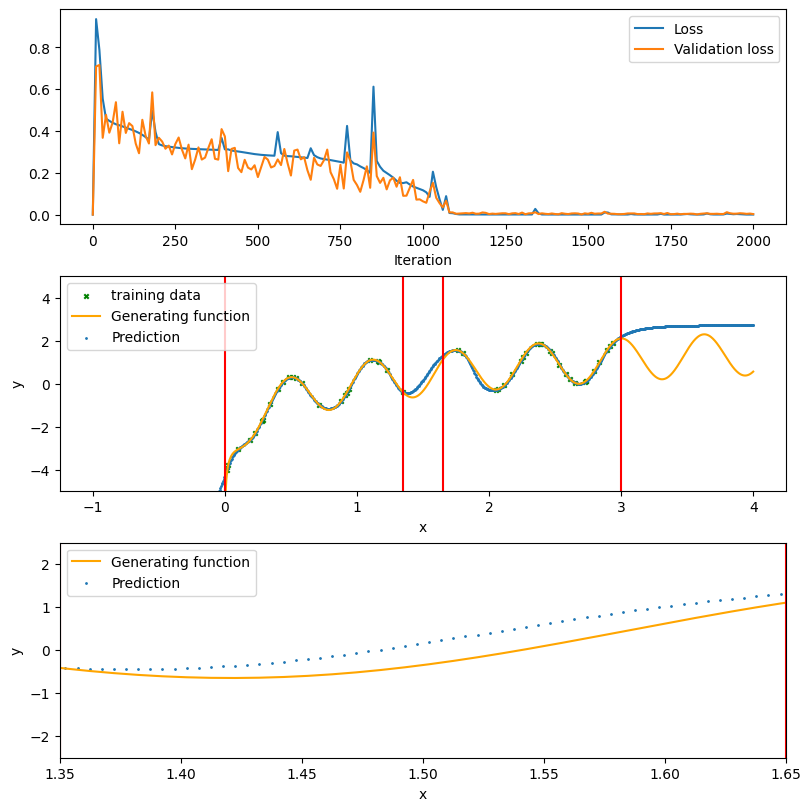

In [171]:
model = NeuralNetwork(L=512, n_hidden=3, activation="tanh", in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_dataset = torch.utils.data.TensorDataset(X_train[0:50], Y_train[0:50])
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=50, epochs = 2000, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
axs[1].scatter(X_train[0:50].flatten().cpu().numpy(), Y_train[0:50].flatten().cpu().numpy(), 
               marker="x", c ="green", s=10, alpha=1, label = "training data")
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)


### Tanh activation function, Adam optimizer, 512 nodes in 3 hidden layers, 20 datapoints

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1423.33it/s]


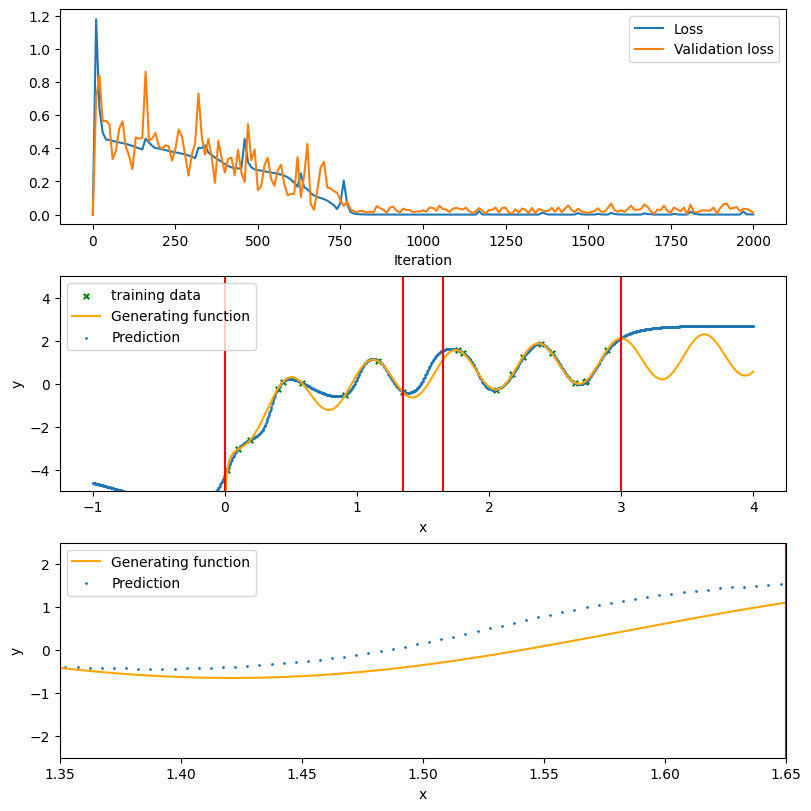

In [173]:
model = NeuralNetwork(L=512, n_hidden=3, activation="tanh", in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_dataset = torch.utils.data.TensorDataset(X_train[0:20], Y_train[0:20])
training_results = train(model, train_dataset, 
                         val_dataset, batchsize=20, epochs = 2000, 
                         device = device, optimizer = optimizer)
truth, preds = predict(model, test_dataset, 1, device)
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8), layout="constrained")
axs[1].scatter(X_train[0:20].flatten().cpu().numpy(), Y_train[0:20].flatten().cpu().numpy(), 
               marker="x", c ="green", s=15, alpha=1, label = "training data")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[1], zoom=False)
plot_preds(X_test, Y_test, preds, xmin, xmax, int_step, axs[2], zoom=True)